# Video Metadata Analysis with PySpark

This notebook uses **PySpark** to extract video metadata in parallel across worker nodes, then displays distribution graphs.

**Features:**
- **Distributed processing**: Uses all worker nodes to extract metadata in parallel
- **Fast**: Processes multiple videos simultaneously
- **Visualizations**: Creates distribution graphs for format, duration, and resolution

**Data Source**: `hdfs:///user/jason/raw_arcticskies/TheArcticSkies/`


## 1. Setup and Configuration

**Important:** Before running this notebook, configure the following settings in the next cell:

1. **TOTAL_WORKER_CORES**: Total number of CPU cores across all worker nodes
   - Example: 10 workers × 2 vCPU = 20 cores
   - Example: 5 workers × 4 vCPU = 20 cores

2. **FFPROBE_PATH**: Full path to the `ffprobe` executable
   - Example: `/opt/conda/default/bin/ffprobe` (Dataproc with conda)
   - Example: `/usr/bin/ffprobe` (standard Linux)
   - **Required**: Must be set to a valid path

3. **SOURCE_PATH**: HDFS path to your video files

4. **VIDEO_EXT**: Video file extension (e.g., `.mp4`)


In [1]:
import os
import subprocess
import tempfile
import json
from pathlib import Path
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, countDistinct, mean, min as spark_min, max as spark_max, stddev
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ============================================================================
# CONFIGURATION - Adjust these values for your cluster
# ============================================================================

# Cluster Configuration
TOTAL_WORKER_CORES = 20  # Total number of cores across all worker nodes
# Example: 10 workers × 2 vCPU = 20 cores
# Example: 5 workers × 4 vCPU = 20 cores

# ffprobe Configuration
FFPROBE_PATH = "/opt/conda/default/bin/ffprobe"  # Full path to ffprobe executable
# Common paths:
#   - "/opt/conda/default/bin/ffprobe" (Dataproc with conda)
#   - "/usr/bin/ffprobe" (standard Linux)
#   - "/usr/local/bin/ffprobe" (custom installation)

# HDFS Configuration
SOURCE_PATH = "hdfs:///user/jason/raw_arcticskies/TheArcticSkies/"  # Source directory in HDFS
VIDEO_EXT = ".mp4"  # Video file extension to process

# ============================================================================
# End of Configuration
# ============================================================================

logger.info("="*60)
logger.info("CONFIGURATION")
logger.info("="*60)
logger.info(f"Total Worker Cores: {TOTAL_WORKER_CORES}")
logger.info(f"ffprobe Path: {FFPROBE_PATH}")
logger.info(f"Source Path: {SOURCE_PATH}")
logger.info(f"Video Extension: {VIDEO_EXT}")
logger.info("="*60)


INFO:__main__:============================================================
INFO:__main__:CONFIGURATION
INFO:__main__:============================================================
INFO:__main__:Total Worker Cores: 20
INFO:__main__:ffprobe Path: /opt/conda/default/bin/ffprobe
INFO:__main__:Source Path: hdfs:///user/jason/raw_arcticskies/TheArcticSkies/
INFO:__main__:Video Extension: .mp4
INFO:__main__:============================================================


## 2. Initialize Spark Session


In [2]:
# Get or create Spark session (Dataproc automatically configures Spark)
# Configure parallelism based on cluster resources
# Use configured total worker cores for parallelism
spark = SparkSession.builder \
    .appName("Video Metadata Analysis - Distributed") \
    .config("spark.default.parallelism", str(TOTAL_WORKER_CORES)) \
    .config("spark.sql.shuffle.partitions", str(TOTAL_WORKER_CORES)) \
    .getOrCreate()

sc = spark.sparkContext

logger.info(f"Spark version: {spark.version}")
logger.info(f"Spark master: {sc.master}")
logger.info(f"Default parallelism: {sc.defaultParallelism}")
logger.info(f"Spark SQL shuffle partitions: {spark.conf.get('spark.sql.shuffle.partitions')}")

# Check executor information
try:
    executors = sc._jsc.sc().getExecutorMemoryStatus().keySet().size()
    logger.info(f"Number of executors: {executors}")
except:
    logger.info("Could not retrieve executor count (may need to run a job first)")

# Display Spark configuration
logger.info("\nKey Spark configurations:")
logger.info(f"  spark.default.parallelism: {spark.conf.get('spark.default.parallelism')}")
logger.info(f"  spark.sql.shuffle.partitions: {spark.conf.get('spark.sql.shuffle.partitions')}")


25/11/17 11:57:23 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
INFO:__main__:Spark version: 3.5.3
INFO:__main__:Spark master: yarn
INFO:__main__:Default parallelism: 2
INFO:__main__:Spark SQL shuffle partitions: 20
INFO:__main__:Number of executors: 1
INFO:__main__:
Key Spark configurations:
INFO:__main__:  spark.default.parallelism: 20
INFO:__main__:  spark.sql.shuffle.partitions: 20


## 3. List Video Files from HDFS


In [3]:
def list_hdfs_files(hdfs_path, file_extension=""):
    """
    List files from HDFS path using Hadoop filesystem commands.
    """
    try:
        cmd = ["hadoop", "fs", "-ls", "-R", hdfs_path]
        result = subprocess.run(
            cmd,
            capture_output=True,
            text=True,
            timeout=60
        )
        
        if result.returncode != 0:
            logger.error(f"Failed to list HDFS files: {result.stderr}")
            return []
        
        files = []
        for line in result.stdout.split("\n"):
            if line.strip() and not line.startswith("Found"):
                parts = line.split()
                if len(parts) >= 8:
                    file_path = parts[-1]
                    if file_extension == "" or file_path.endswith(file_extension):
                        files.append(file_path)
        
        logger.info(f"Found {len(files)} files with extension '{file_extension}' in {hdfs_path}")
        return files
    except Exception as e:
        logger.error(f"Error listing HDFS files: {e}")
        return []

# List all MP4 files
video_files = list_hdfs_files(SOURCE_PATH, VIDEO_EXT)

if len(video_files) == 0:
    logger.warning(f"No {VIDEO_EXT} files found in {SOURCE_PATH}")
else:
    logger.info(f"Found {len(video_files)} video files to process")
    for i, video_file in enumerate(video_files[:5]):
        print(f"  {i+1}. {video_file}")
    if len(video_files) > 5:
        print(f"  ... and {len(video_files) - 5} more files")


INFO:__main__:Found 54 files with extension '.mp4' in hdfs:///user/jason/raw_arcticskies/TheArcticSkies/
INFO:__main__:Found 54 video files to process


  1. hdfs:///user/jason/raw_arcticskies/TheArcticSkies/Kiruna,_Swedish_Lapland_Northern_Lights_December_21st_2024.mp4
  2. hdfs:///user/jason/raw_arcticskies/TheArcticSkies/Kiruna,_Swedish_Lapland_Northern_Lights_December_24th_2024.mp4
  3. hdfs:///user/jason/raw_arcticskies/TheArcticSkies/Kiruna,_Swedish_Lapland_Northern_Lights_December_31st_2024__New_year_celebration!_.mp4
  4. hdfs:///user/jason/raw_arcticskies/TheArcticSkies/Kiruna,_Swedish_Lapland_Northern_Lights_December_8th_2024.mp4
  5. hdfs:///user/jason/raw_arcticskies/TheArcticSkies/Kiruna,_Swedish_Lapland_Northern_Lights_December_9th_2024.mp4
  ... and 49 more files


## 4. Verify ffprobe Installation


In [4]:
# Check ffprobe using configured path
if FFPROBE_PATH:
    try:
        if os.path.exists(FFPROBE_PATH) and os.access(FFPROBE_PATH, os.X_OK):
            logger.info(f"Using configured ffprobe path: {FFPROBE_PATH}")
            result = subprocess.run(
                [FFPROBE_PATH, "-version"],
                capture_output=True,
                text=True,
                timeout=10
            )
            if result.returncode == 0:
                logger.info("ffprobe is available:")
                print(result.stdout.split("\n")[0])
            else:
                logger.error(f"ffprobe check failed: {result.stderr}")
        else:
            logger.warning(f"Configured ffprobe path does not exist or is not executable: {FFPROBE_PATH}")
    except Exception as e:
        logger.error(f"Error checking ffprobe: {e}")
else:
    logger.warning("FFPROBE_PATH is not configured. Please set it in the configuration section.")


INFO:__main__:Using configured ffprobe path: /opt/conda/default/bin/ffprobe
INFO:__main__:ffprobe is available:


ffprobe version 6.1.1 Copyright (c) 2007-2023 the FFmpeg developers


## 5. Extract Video Metadata Function (Runs on Workers)

This function will be executed on each worker node in parallel.


In [5]:
def extract_video_metadata(video_hdfs_path):
    """
    Extract metadata from a video file using ffprobe.
    This function runs on worker nodes.
    
    Args:
        video_hdfs_path: HDFS path to the video file
    
    Returns:
        Dictionary with video metadata or None if failed
    """
    # Use configured ffprobe path
    # FFPROBE_PATH is captured from the outer scope when this function is defined
    if not FFPROBE_PATH:
        return {
            "filename": Path(video_hdfs_path).name,
            "path": video_hdfs_path,
            "format": None,
            "duration_seconds": None,
            "duration_minutes": None,
            "width": None,
            "height": None,
            "resolution": None,
            "codec": None,
            "status": "failed",
            "error": f"FFPROBE_PATH is not configured. Please set FFPROBE_PATH in the configuration section."
        }
    
    temp_dir = None
    local_video_path = None
    try:
        # Create temporary directory and file path
        # Use tempfile.mkdtemp to create a unique temp directory
        temp_dir = tempfile.mkdtemp()
        video_filename = Path(video_hdfs_path).name
        local_video_path = os.path.join(temp_dir, video_filename)
        
        # Download video from HDFS to local temp
        # hadoop fs -get will create the file, so we don't need to create it first
        download_cmd = ["hadoop", "fs", "-get", video_hdfs_path, local_video_path]
        download_result = subprocess.run(
            download_cmd,
            capture_output=True,
            text=True,
            timeout=300
        )
        
        if download_result.returncode != 0:
            return {
                "filename": Path(video_hdfs_path).name,
                "path": video_hdfs_path,
                "format": None,
                "duration_seconds": None,
                "duration_minutes": None,
                "width": None,
                "height": None,
                "resolution": None,
                "codec": None,
                "status": "failed",
                "error": f"Download failed: {download_result.stderr}"
            }
        
        # Use ffprobe to get metadata in JSON format
        # Use configured path to ffprobe
        ffprobe_cmd = [
            FFPROBE_PATH,
            "-v", "quiet",
            "-print_format", "json",
            "-show_format",
            "-show_streams",
            local_video_path
        ]
        
        ffprobe_result = subprocess.run(
            ffprobe_cmd,
            capture_output=True,
            text=True,
            timeout=60
        )
        
        if ffprobe_result.returncode != 0:
            return {
                "filename": Path(video_hdfs_path).name,
                "path": video_hdfs_path,
                "format": None,
                "duration_seconds": None,
                "duration_minutes": None,
                "width": None,
                "height": None,
                "resolution": None,
                "codec": None,
                "status": "failed",
                "error": f"ffprobe failed: {ffprobe_result.stderr}"
            }
        
        # Parse JSON metadata
        metadata = json.loads(ffprobe_result.stdout)
        
        # Find video stream
        video_stream = None
        for stream in metadata.get("streams", []):
            if stream.get("codec_type") == "video":
                video_stream = stream
                break
        
        if video_stream is None:
            return {
                "filename": Path(video_hdfs_path).name,
                "path": video_hdfs_path,
                "format": None,
                "duration_seconds": None,
                "duration_minutes": None,
                "width": None,
                "height": None,
                "resolution": None,
                "codec": None,
                "status": "failed",
                "error": "No video stream found"
            }
        
        # Extract metadata
        format_name = metadata.get("format", {}).get("format_name", "unknown")
        duration = float(metadata.get("format", {}).get("duration", 0))
        width = int(video_stream.get("width", 0))
        height = int(video_stream.get("height", 0))
        codec = video_stream.get("codec_name", "unknown")
        
        return {
            "filename": Path(video_hdfs_path).name,
            "path": video_hdfs_path,
            "format": format_name,
            "duration_seconds": duration,
            "duration_minutes": duration / 60.0,
            "width": width,
            "height": height,
            "resolution": f"{width}x{height}",
            "codec": codec,
            "status": "success",
            "error": None
        }
        
    except Exception as e:
        return {
            "filename": Path(video_hdfs_path).name if video_hdfs_path else "unknown",
            "path": video_hdfs_path,
            "format": None,
            "duration_seconds": None,
            "duration_minutes": None,
            "width": None,
            "height": None,
            "resolution": None,
            "codec": None,
            "status": "failed",
            "error": str(e)
        }
    finally:
        # Clean up temp directory and file
        if temp_dir and os.path.exists(temp_dir):
            try:
                # Remove the video file if it exists
                if local_video_path and os.path.exists(local_video_path):
                    os.unlink(local_video_path)
                # Remove the temp directory
                os.rmdir(temp_dir)
            except Exception as e:
                # If cleanup fails, try to remove just the file
                try:
                    if local_video_path and os.path.exists(local_video_path):
                        os.unlink(local_video_path)
                except:
                    pass


In [6]:
if len(video_files) > 0:
    # Create RDD of video files
    # Use parallelism based on configured cluster size
    # Create more partitions than cores for better load balancing
    # Force at least TOTAL_WORKER_CORES partitions to utilize all workers
    target_partitions = min(len(video_files), max(int(spark.conf.get('spark.default.parallelism', '2')), TOTAL_WORKER_CORES))
    video_rdd = sc.parallelize(
        video_files,
        numSlices=target_partitions
    )
    
    logger.info(f"Created RDD with {video_rdd.getNumPartitions()} partitions")
    logger.info(f"Processing {len(video_files)} videos")
    logger.info(f"Default parallelism setting: {spark.conf.get('spark.default.parallelism')}")
    logger.info(f"Actual RDD partitions: {video_rdd.getNumPartitions()}")
    logger.info(f"Target was: {target_partitions}")
    
    # Process videos in parallel
    results_rdd = video_rdd.map(extract_video_metadata)
    
    # Collect results
    results = results_rdd.collect()
    
    # Define explicit schema for metadata DataFrame
    metadata_schema = StructType([
        StructField("filename", StringType(), True),
        StructField("path", StringType(), True),
        StructField("format", StringType(), True),
        StructField("duration_seconds", DoubleType(), True),
        StructField("duration_minutes", DoubleType(), True),
        StructField("width", IntegerType(), True),
        StructField("height", IntegerType(), True),
        StructField("resolution", StringType(), True),
        StructField("codec", StringType(), True),
        StructField("status", StringType(), True),
        StructField("error", StringType(), True)
    ])
    
    # Convert to Spark DataFrame with explicit schema
    # Handle None values by converting them to appropriate types
    cleaned_results = []
    for result in results:
        cleaned_result = {
            "filename": result.get("filename") or "",
            "path": result.get("path") or "",
            "format": result.get("format") or "",
            "duration_seconds": float(result.get("duration_seconds")) if result.get("duration_seconds") is not None else None,
            "duration_minutes": float(result.get("duration_minutes")) if result.get("duration_minutes") is not None else None,
            "width": int(result.get("width")) if result.get("width") is not None else None,
            "height": int(result.get("height")) if result.get("height") is not None else None,
            "resolution": result.get("resolution") or "",
            "codec": result.get("codec") or "",
            "status": result.get("status") or "",
            "error": result.get("error") or ""
        }
        cleaned_results.append(cleaned_result)
    
    metadata_df = spark.createDataFrame(cleaned_results, schema=metadata_schema)
    
    # Filter successful extractions
    successful_df = metadata_df.filter(col("status") == "success")
    failed_df = metadata_df.filter(col("status") == "failed")
    
    successful_count = successful_df.count()
    failed_count = failed_df.count()
    
    print("\n" + "="*60)
    print("METADATA EXTRACTION SUMMARY")
    print("="*60)
    print(f"Total videos processed: {len(results)}")
    print(f"Successful: {successful_count}")
    print(f"Failed: {failed_count}")
    print("="*60)
    
    if failed_count > 0:
        print("\nFailed videos:")
        failed_df.select("filename", "error").show(truncate=False)
    
    # Show sample successful results
    if successful_count > 0:
        print("\nSample successful extractions:")
        successful_df.select("filename", "format", "duration_minutes", "resolution").show(10, truncate=False)
else:
    print("No videos to process.")
    successful_df = None


INFO:__main__:Created RDD with 20 partitions
INFO:__main__:Processing 54 videos
INFO:__main__:Default parallelism setting: 20
INFO:__main__:Actual RDD partitions: 20
INFO:__main__:Target was: 20



METADATA EXTRACTION SUMMARY
Total videos processed: 54
Successful: 54
Failed: 0

Sample successful extractions:
+--------------------------------------------------------------------------------------+------+------------------+----------+
|filename                                                                              |format|duration_minutes  |resolution|
+--------------------------------------------------------------------------------------+------+------------------+----------+
|Kiruna,_Swedish_Lapland_Northern_Lights_December_21st_2024.mp4                        |mpegts|2.84521815        |1920x1080 |
|Kiruna,_Swedish_Lapland_Northern_Lights_December_24th_2024.mp4                        |mpegts|1.55694445        |1920x1080 |
|Kiruna,_Swedish_Lapland_Northern_Lights_December_31st_2024__New_year_celebration!_.mp4|mpegts|11.943183516666666|1920x1080 |
|Kiruna,_Swedish_Lapland_Northern_Lights_December_8th_2024.mp4                         |mpegts|3.6180557333333336|1920x1080 |
|Kiru

## 7. Load Visualization Libraries


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style (try different style names for compatibility)
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette("husl")

# Configure matplotlib for better quality
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

print("Visualization libraries loaded.")


Visualization libraries loaded.


## 8. Video Format Distribution


Video Format Distribution:
format  count  percentage
mpegts     54       100.0


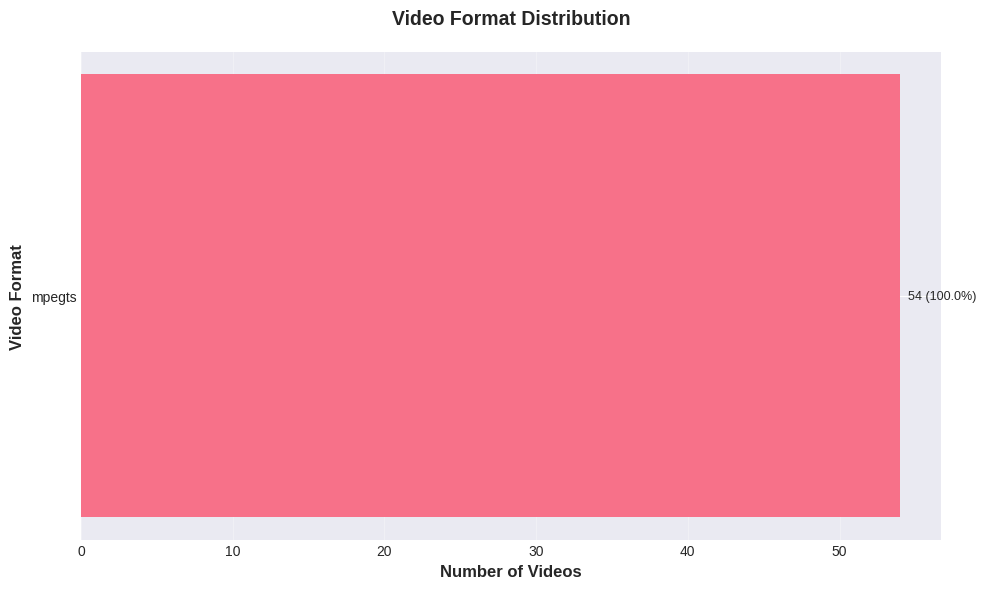

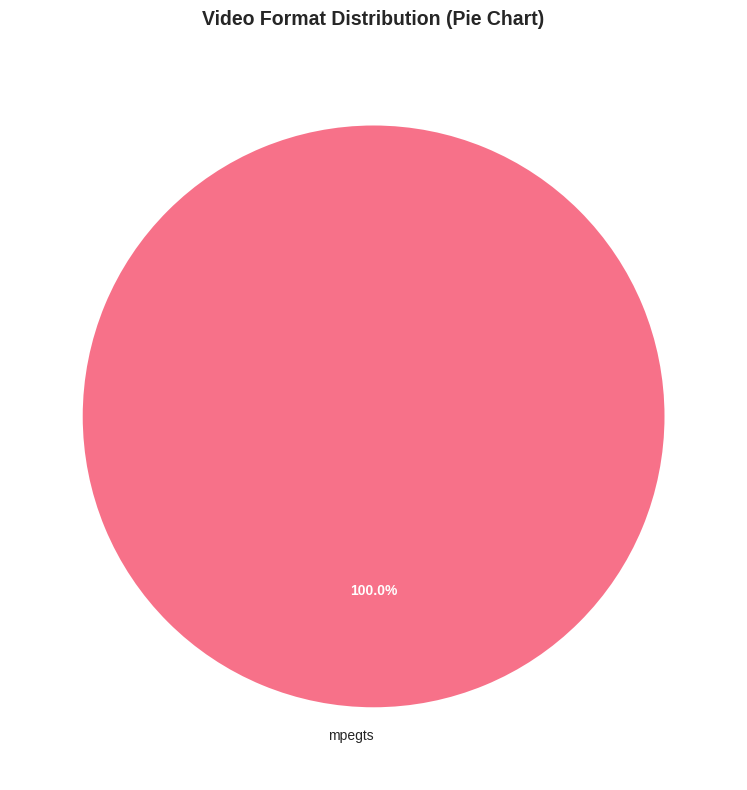

In [8]:
if successful_df is not None and successful_df.count() > 0:
    # Get format distribution using Spark
    format_counts = successful_df.groupBy("format").agg(count("*").alias("count")) \
        .orderBy(col("count").desc()) \
        .toPandas()
    
    # Calculate percentages
    total = format_counts["count"].sum()
    format_counts["percentage"] = (format_counts["count"] / total * 100).round(1)
    
    print("Video Format Distribution:")
    print(format_counts.to_string(index=False))
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(format_counts["format"], format_counts["count"], color=sns.color_palette("husl", len(format_counts)))
    
    # Add value labels
    for i, (idx, row) in enumerate(format_counts.iterrows()):
        ax.text(row["count"] + max(format_counts["count"]) * 0.01, i, 
                f'{int(row["count"])} ({row["percentage"]}%)',
                va='center', fontsize=9)
    
    ax.set_xlabel("Number of Videos", fontsize=12, fontweight='bold')
    ax.set_ylabel("Video Format", fontsize=12, fontweight='bold')
    ax.set_title("Video Format Distribution", fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Alternative: Pie chart
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = sns.color_palette("husl", len(format_counts))
    wedges, texts, autotexts = ax.pie(format_counts["count"], 
                                       labels=format_counts["format"],
                                       autopct='%1.1f%%',
                                       colors=colors,
                                       startangle=90)
    
    # Improve text appearance
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    ax.set_title("Video Format Distribution (Pie Chart)", fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
else:
    print("No successful video extractions to analyze.")


## 9. Video Length (Duration) Distribution


Duration Statistics (in minutes):
  Mean:   7.06
  Median: 6.32
  Min:    0.84
  Max:    31.58
  StdDev: 4.69


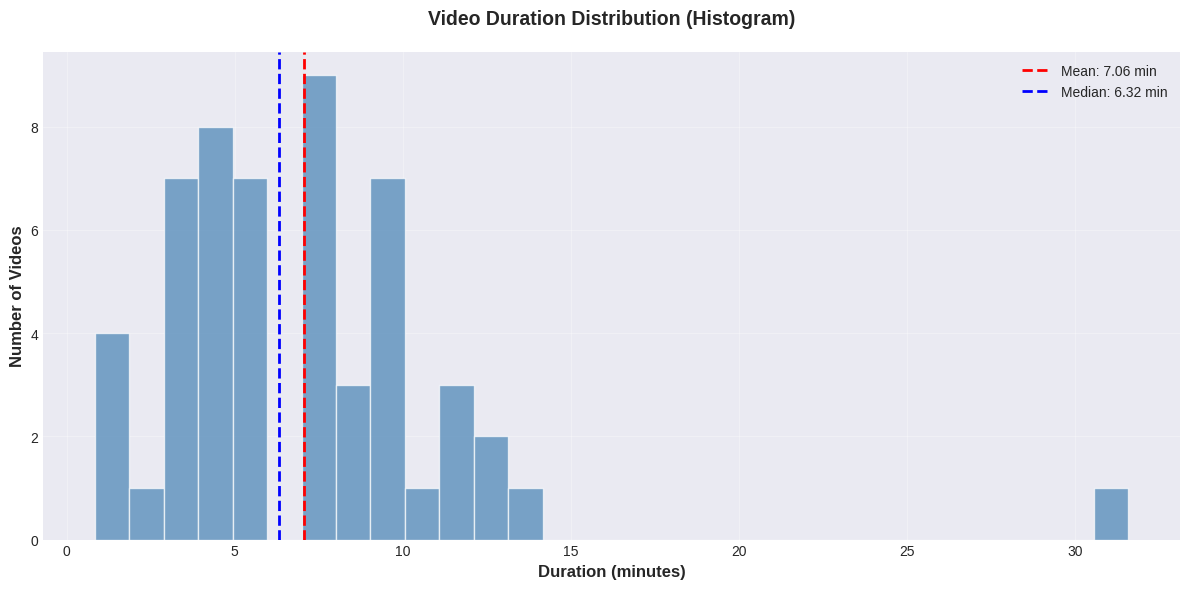

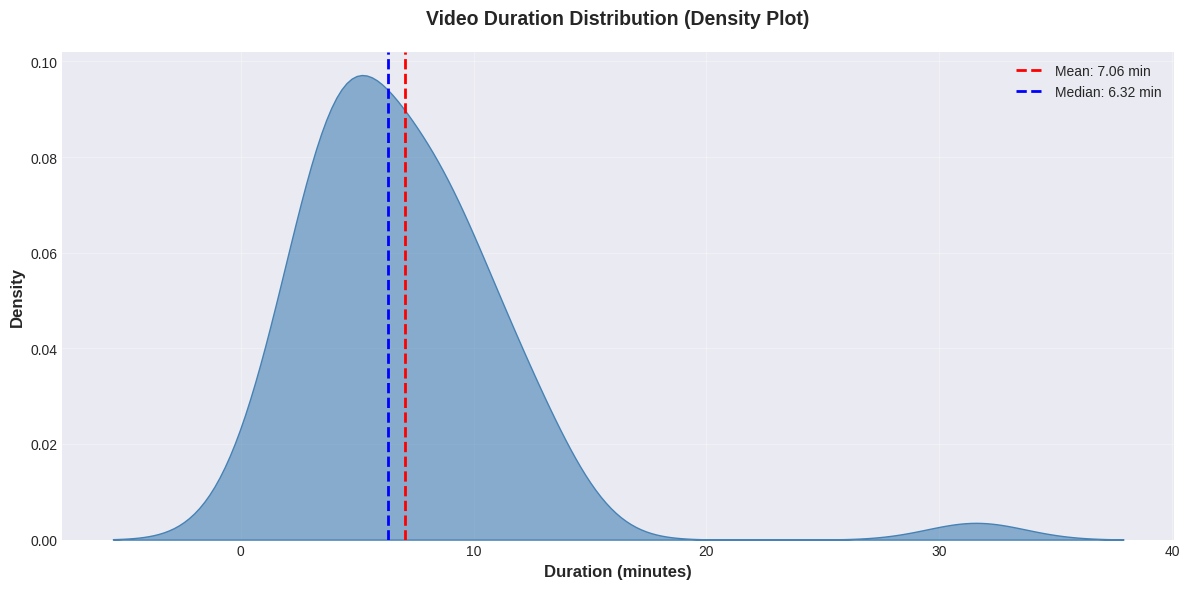

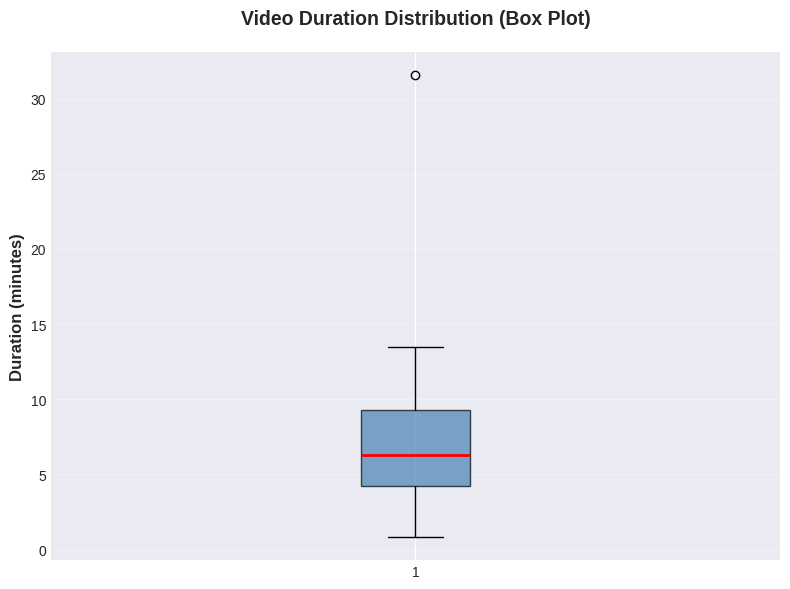

In [9]:
if successful_df is not None and successful_df.count() > 0:
    # Get summary statistics using Spark
    duration_stats = successful_df.agg(
        mean("duration_minutes").alias("mean"),
        spark_min("duration_minutes").alias("min"),
        spark_max("duration_minutes").alias("max"),
        stddev("duration_minutes").alias("stddev")
    ).collect()[0]
    
    # Calculate median (Spark doesn't have direct median, so we'll use pandas for this)
    duration_pandas = successful_df.select("duration_minutes").toPandas()
    median_duration = duration_pandas["duration_minutes"].median()
    
    print("Duration Statistics (in minutes):")
    print(f"  Mean:   {duration_stats['mean']:.2f}")
    print(f"  Median: {median_duration:.2f}")
    print(f"  Min:    {duration_stats['min']:.2f}")
    print(f"  Max:    {duration_stats['max']:.2f}")
    print(f"  StdDev: {duration_stats['stddev']:.2f}")
    
    # Convert to pandas for plotting
    duration_data = successful_df.select("duration_minutes").toPandas()
    
    # Histogram
    fig, ax = plt.subplots(figsize=(12, 6))
    n, bins, patches = ax.hist(duration_data["duration_minutes"], bins=30, 
                               color='steelblue', edgecolor='white', alpha=0.7)
    
    # Add mean line
    mean_val = duration_stats['mean']
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f} min')
    ax.axvline(median_duration, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_duration:.2f} min')
    
    ax.set_xlabel("Duration (minutes)", fontsize=12, fontweight='bold')
    ax.set_ylabel("Number of Videos", fontsize=12, fontweight='bold')
    ax.set_title("Video Duration Distribution (Histogram)", fontsize=14, fontweight='bold', pad=20)
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Density plot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.kdeplot(data=duration_data, x="duration_minutes", fill=True, alpha=0.6, color='steelblue')
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f} min')
    ax.axvline(median_duration, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_duration:.2f} min')
    
    ax.set_xlabel("Duration (minutes)", fontsize=12, fontweight='bold')
    ax.set_ylabel("Density", fontsize=12, fontweight='bold')
    ax.set_title("Video Duration Distribution (Density Plot)", fontsize=14, fontweight='bold', pad=20)
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Box plot
    fig, ax = plt.subplots(figsize=(8, 6))
    bp = ax.boxplot(duration_data["duration_minutes"], vert=True, patch_artist=True,
                    boxprops=dict(facecolor='steelblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
    
    ax.set_ylabel("Duration (minutes)", fontsize=12, fontweight='bold')
    ax.set_title("Video Duration Distribution (Box Plot)", fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No successful video extractions to analyze.")


Video Resolution Distribution:
resolution  count  percentage
 1920x1080     54       100.0


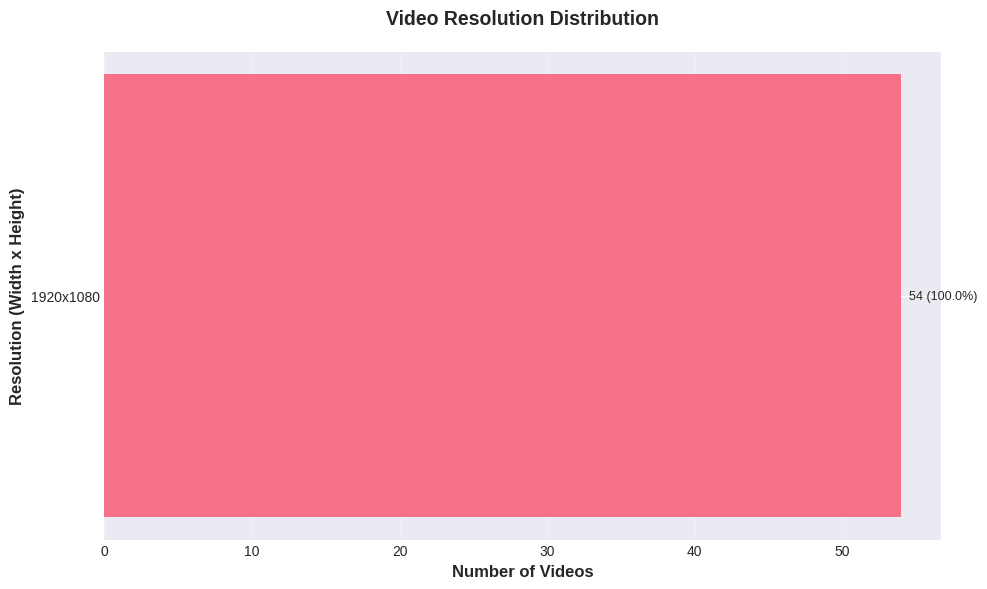

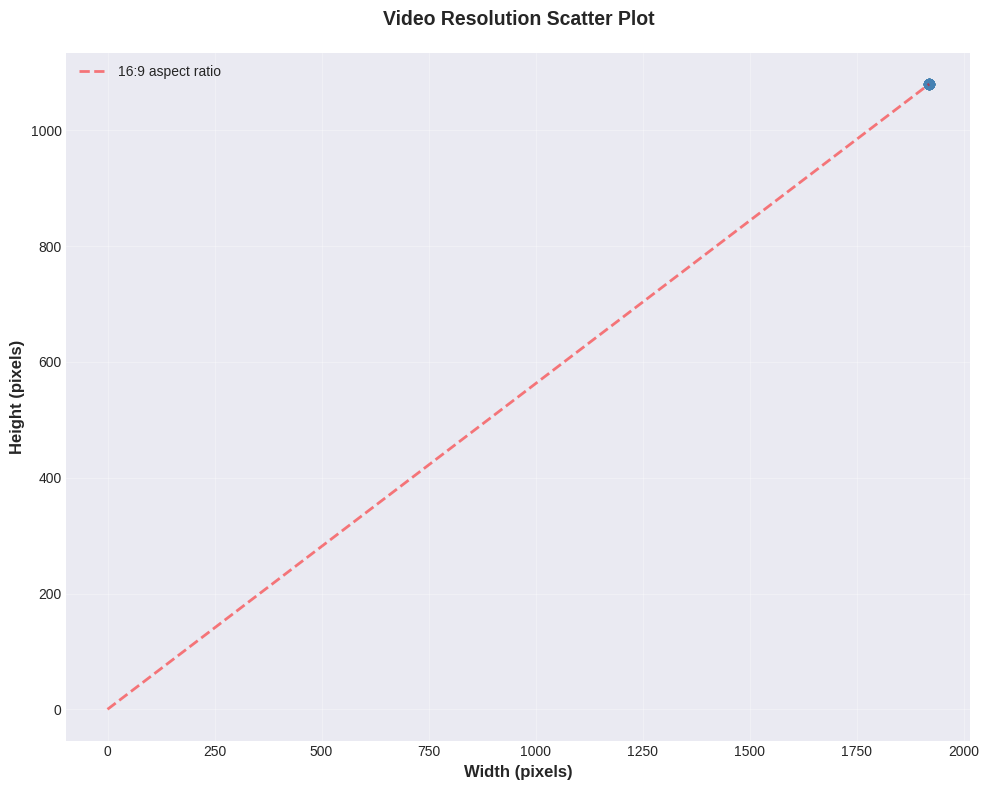

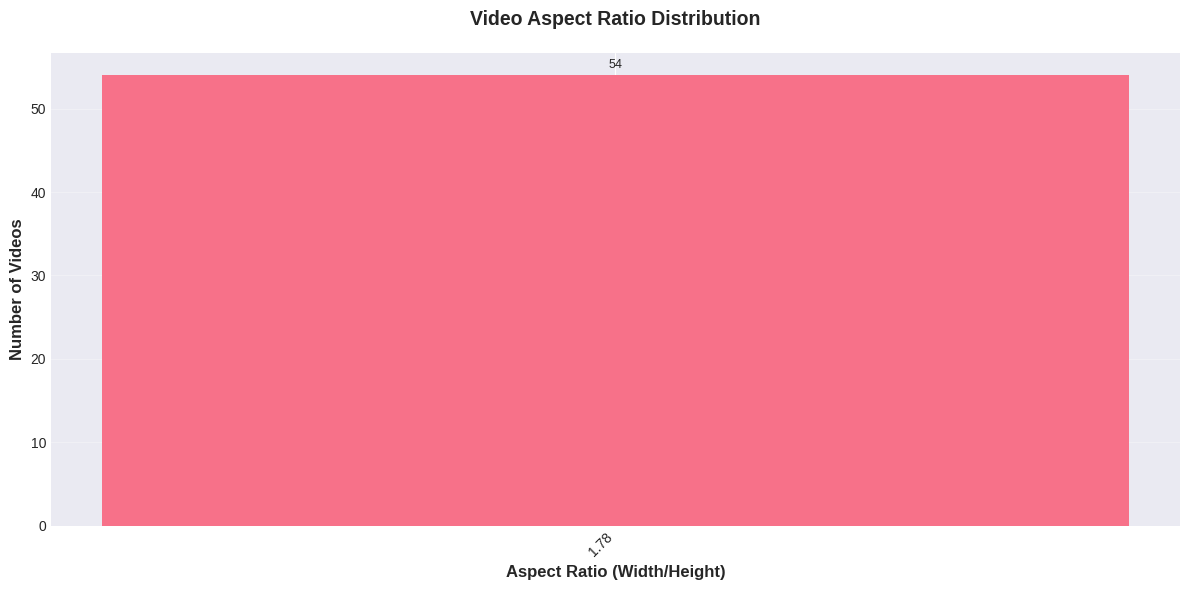

In [10]:
if successful_df is not None and successful_df.count() > 0:
    # Get resolution distribution using Spark
    resolution_counts = successful_df.groupBy("resolution").agg(count("*").alias("count")) \
        .orderBy(col("count").desc()) \
        .toPandas()
    
    # Calculate percentages
    total = resolution_counts["count"].sum()
    resolution_counts["percentage"] = (resolution_counts["count"] / total * 100).round(1)
    
    print("Video Resolution Distribution:")
    print(resolution_counts.to_string(index=False))
    
    # Bar plot for resolution
    fig, ax = plt.subplots(figsize=(10, max(6, len(resolution_counts) * 0.3)))
    bars = ax.barh(resolution_counts["resolution"], resolution_counts["count"], 
                    color=sns.color_palette("husl", len(resolution_counts)))
    
    # Add value labels
    for i, (idx, row) in enumerate(resolution_counts.iterrows()):
        ax.text(row["count"] + max(resolution_counts["count"]) * 0.01, i,
                f'{int(row["count"])} ({row["percentage"]}%)',
                va='center', fontsize=9)
    
    ax.set_xlabel("Number of Videos", fontsize=12, fontweight='bold')
    ax.set_ylabel("Resolution (Width x Height)", fontsize=12, fontweight='bold')
    ax.set_title("Video Resolution Distribution", fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Scatter plot: Width vs Height
    resolution_data = successful_df.select("width", "height").toPandas()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(resolution_data["width"], resolution_data["height"], 
                        alpha=0.6, s=50, color='steelblue')
    
    # Add 16:9 aspect ratio line
    max_dim = max(resolution_data["width"].max(), resolution_data["height"].max())
    x_line = np.linspace(0, max_dim, 100)
    y_line = x_line * 9 / 16
    ax.plot(x_line, y_line, 'r--', alpha=0.5, linewidth=2, label='16:9 aspect ratio')
    
    ax.set_xlabel("Width (pixels)", fontsize=12, fontweight='bold')
    ax.set_ylabel("Height (pixels)", fontsize=12, fontweight='bold')
    ax.set_title("Video Resolution Scatter Plot", fontsize=14, fontweight='bold', pad=20)
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and plot aspect ratio distribution
    resolution_data["aspect_ratio"] = (resolution_data["width"] / resolution_data["height"]).round(2)
    aspect_counts = resolution_data["aspect_ratio"].value_counts().sort_index()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(range(len(aspect_counts)), aspect_counts.values, 
                  color=sns.color_palette("husl", len(aspect_counts)))
    
    ax.set_xticks(range(len(aspect_counts)))
    ax.set_xticklabels([f"{ar:.2f}" for ar in aspect_counts.index], rotation=45, ha='right')
    ax.set_xlabel("Aspect Ratio (Width/Height)", fontsize=12, fontweight='bold')
    ax.set_ylabel("Number of Videos", fontsize=12, fontweight='bold')
    ax.set_title("Video Aspect Ratio Distribution", fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (ar, count) in enumerate(aspect_counts.items()):
        ax.text(i, count + max(aspect_counts.values) * 0.01, 
                f'{int(count)}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("No successful video extractions to analyze.")
